In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_simple = SimpleCNN()


In [3]:
# Function to plot training progress
def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Train the network and save history for plotting
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

In [4]:
# Set up the optimizer.SGD with learning rate 0.001
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(net_simple.parameters(), lr=0.001, momentum=0.9)


Epoch 1, Train loss: 1.69, Accuracy: 37.65%, Validation loss: 1.46, Validation Accuracy: 46.71%
Epoch 2, Train loss: 1.31, Accuracy: 53.19%, Validation loss: 1.23, Validation Accuracy: 55.99%


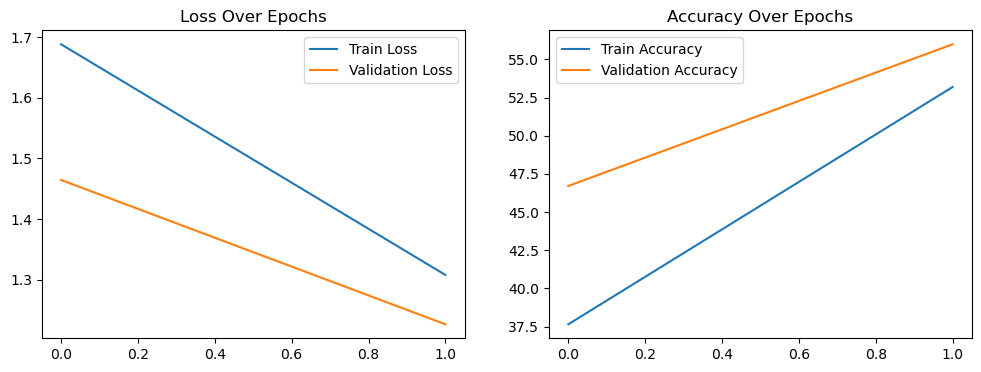

              precision    recall  f1-score   support

       plane       0.66      0.56      0.61      1000
         car       0.64      0.77      0.70      1000
        bird       0.61      0.23      0.34      1000
         cat       0.35      0.45      0.40      1000
        deer       0.48      0.46      0.47      1000
         dog       0.52      0.37      0.43      1000
        frog       0.60      0.70      0.65      1000
       horse       0.58      0.69      0.63      1000
        ship       0.62      0.75      0.68      1000
       truck       0.59      0.61      0.60      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.55     10000
weighted avg       0.56      0.56      0.55     10000



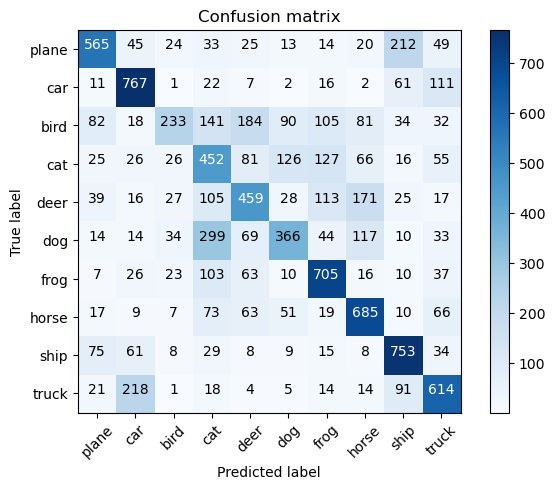

In [5]:
# Training
for epoch in range(2):  # loop over the dataset multiple times
    train_loss, valid_loss = 0.0, 0.0
    correct, total = 0, 0
    
    # Training loop
    net_simple.train()
    for data in trainloader:
        inputs, labels = data
        optimizer_sgd.zero_grad()
        outputs = net_simple(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation loop
    net_simple.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_simple(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)

    print(f'Epoch {epoch+1}, Train loss: {train_loss / len(trainloader):.2f}, Accuracy: {100 * correct / total:.2f}%, Validation loss: {valid_loss / len(testloader):.2f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')

plot_training(history)

# Testing the network and plotting confusion matrix
y_pred = []
y_true = []
net_simple.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = net_simple(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Classification Report
print(classification_report(y_true, y_pred, target_names=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Train loss: 1.71, Accuracy: 37.06%, Validation loss: 1.38, Validation Accuracy: 50.29%
Epoch 2, Train loss: 1.33, Accuracy: 52.39%, Validation loss: 1.28, Validation Accuracy: 55.16%


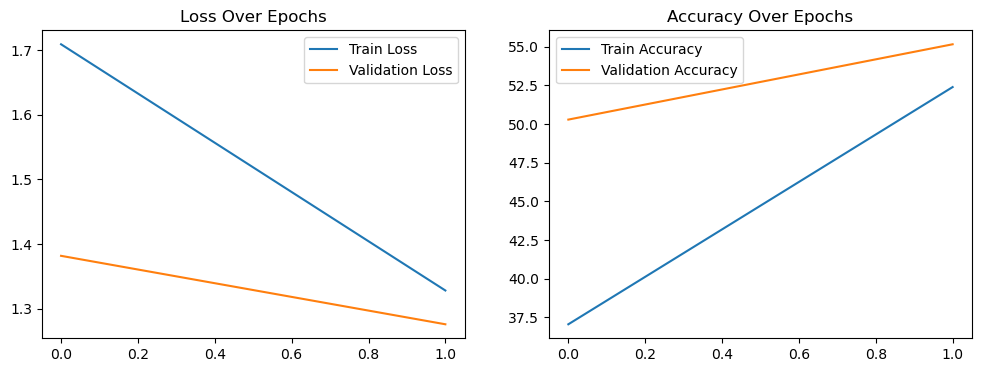

              precision    recall  f1-score   support

       plane       0.64      0.63      0.63      1000
         car       0.57      0.82      0.67      1000
        bird       0.47      0.32      0.38      1000
         cat       0.45      0.30      0.36      1000
        deer       0.40      0.54      0.46      1000
         dog       0.52      0.45      0.48      1000
        frog       0.48      0.84      0.61      1000
       horse       0.71      0.60      0.65      1000
        ship       0.71      0.64      0.67      1000
       truck       0.74      0.38      0.50      1000

    accuracy                           0.55     10000
   macro avg       0.57      0.55      0.54     10000
weighted avg       0.57      0.55      0.54     10000



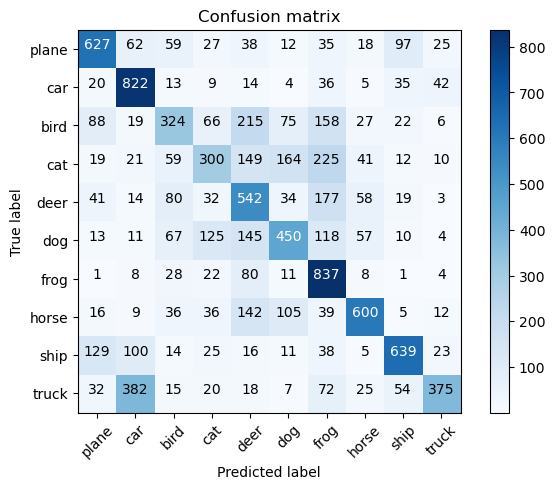

In [6]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

# Function to plot training progress
def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Train the network and save history for plotting
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_simple = SimpleCNN()

# Set up the optimizer.SGD with learning rate 0.001
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(net_simple.parameters(), lr=0.001, momentum=0.9)

# Training
for epoch in range(2):  # loop over the dataset multiple times
    train_loss, valid_loss = 0.0, 0.0
    correct, total = 0, 0
    
    # Training loop
    net_simple.train()
    for data in trainloader:
        inputs, labels = data
        optimizer_sgd.zero_grad()
        outputs = net_simple(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation loop
    net_simple.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_simple(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)

    print(f'Epoch {epoch+1}, Train loss: {train_loss / len(trainloader):.2f}, Accuracy: {100 * correct / total:.2f}%, Validation loss: {valid_loss / len(testloader):.2f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')

plot_training(history)

# Testing the network and plotting confusion matrix
y_pred = []
y_true = []
net_simple.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = net_simple(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Classification Report
print(classification_report(y_true, y_pred, target_names=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))


Epoch 1, Train loss: 1.19, Accuracy: 57.91%, Validation loss: 1.19, Validation Accuracy: 57.36%
Epoch 2, Train loss: 1.09, Accuracy: 61.54%, Validation loss: 1.09, Validation Accuracy: 62.28%
Epoch 3, Train loss: 1.01, Accuracy: 64.15%, Validation loss: 1.12, Validation Accuracy: 61.49%
Epoch 4, Train loss: 0.96, Accuracy: 66.12%, Validation loss: 1.09, Validation Accuracy: 63.01%
Epoch 5, Train loss: 0.91, Accuracy: 67.93%, Validation loss: 1.15, Validation Accuracy: 61.67%
Epoch 6, Train loss: 0.88, Accuracy: 69.14%, Validation loss: 1.11, Validation Accuracy: 62.43%
Epoch 7, Train loss: 0.84, Accuracy: 70.21%, Validation loss: 1.09, Validation Accuracy: 63.62%
Epoch 8, Train loss: 0.81, Accuracy: 71.08%, Validation loss: 1.11, Validation Accuracy: 62.69%
Epoch 9, Train loss: 0.79, Accuracy: 72.26%, Validation loss: 1.11, Validation Accuracy: 64.34%
Epoch 10, Train loss: 0.77, Accuracy: 72.82%, Validation loss: 1.14, Validation Accuracy: 63.81%


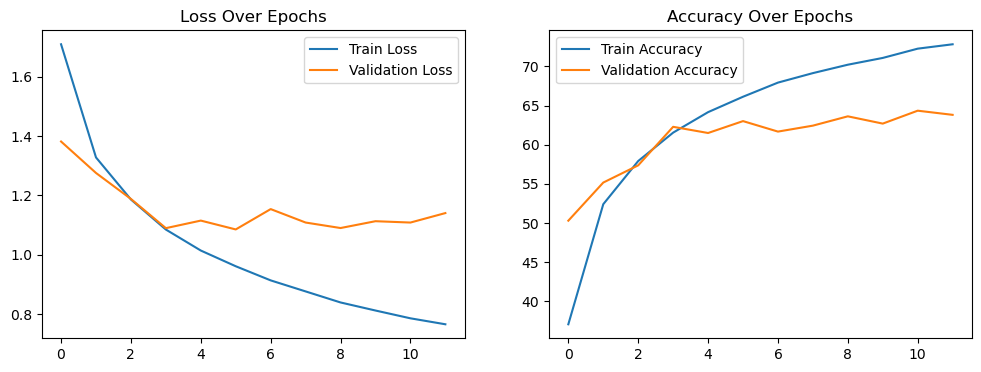

In [7]:
# Increase the number of epochs
num_epochs = 10

for epoch in range(num_epochs):  # loop over the dataset multiple times
    train_loss, valid_loss = 0.0, 0.0
    correct, total = 0, 0
    
    # Training loop
    net_simple.train()
    for data in trainloader:
        inputs, labels = data
        optimizer_sgd.zero_grad()
        outputs = net_simple(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation loop
    net_simple.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_simple(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)

    print(f'Epoch {epoch+1}, Train loss: {train_loss / len(trainloader):.2f}, Accuracy: {100 * correct / total:.2f}%, Validation loss: {valid_loss / len(testloader):.2f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')

plot_training(history)


Epoch 1, Train loss: 0.74, Accuracy: 73.76%, Validation loss: 1.17, Validation Accuracy: 63.39%
Epoch 2, Train loss: 0.73, Accuracy: 74.25%, Validation loss: 1.25, Validation Accuracy: 62.76%
Epoch 3, Train loss: 0.72, Accuracy: 74.47%, Validation loss: 1.18, Validation Accuracy: 62.67%
Epoch 4, Train loss: 0.70, Accuracy: 75.43%, Validation loss: 1.35, Validation Accuracy: 60.65%
Epoch 5, Train loss: 0.69, Accuracy: 75.52%, Validation loss: 1.25, Validation Accuracy: 62.68%
Epoch 6, Train loss: 0.67, Accuracy: 76.20%, Validation loss: 1.30, Validation Accuracy: 61.48%
Epoch 7, Train loss: 0.67, Accuracy: 76.26%, Validation loss: 1.32, Validation Accuracy: 61.79%
Epoch 8, Train loss: 0.66, Accuracy: 76.58%, Validation loss: 1.35, Validation Accuracy: 61.93%
Epoch 9, Train loss: 0.65, Accuracy: 77.16%, Validation loss: 1.39, Validation Accuracy: 60.97%
Epoch 10, Train loss: 0.65, Accuracy: 77.08%, Validation loss: 1.44, Validation Accuracy: 62.15%
Epoch 11, Train loss: 0.64, Accuracy: 7

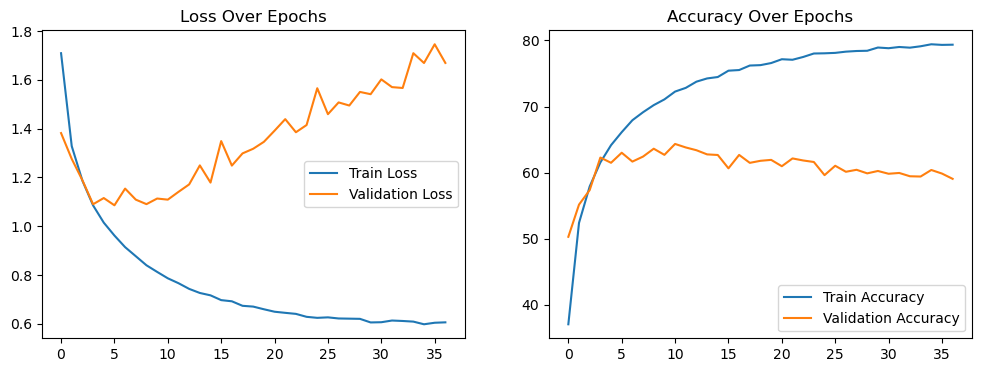

In [8]:
# Increase the number of epochs
num_epochs = 25

for epoch in range(num_epochs):  # loop over the dataset multiple times
    train_loss, valid_loss = 0.0, 0.0
    correct, total = 0, 0
    
    # Training loop
    net_simple.train()
    for data in trainloader:
        inputs, labels = data
        optimizer_sgd.zero_grad()
        outputs = net_simple(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation loop
    net_simple.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_simple(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)

    print(f'Epoch {epoch+1}, Train loss: {train_loss / len(trainloader):.2f}, Accuracy: {100 * correct / total:.2f}%, Validation loss: {valid_loss / len(testloader):.2f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')

plot_training(history)


Epoch 1, Train loss: 0.73, Accuracy: 75.85%, Validation loss: 1.49, Validation Accuracy: 60.31%
Epoch 2, Train loss: 0.73, Accuracy: 75.34%, Validation loss: 1.40, Validation Accuracy: 61.44%
Epoch 3, Train loss: 0.71, Accuracy: 75.52%, Validation loss: 1.40, Validation Accuracy: 60.89%
Epoch 4, Train loss: 0.69, Accuracy: 76.33%, Validation loss: 1.46, Validation Accuracy: 60.69%
Epoch 5, Train loss: 0.67, Accuracy: 77.14%, Validation loss: 1.51, Validation Accuracy: 61.11%
Epoch 6, Train loss: 0.66, Accuracy: 77.66%, Validation loss: 1.41, Validation Accuracy: 60.97%
Epoch 7, Train loss: 0.64, Accuracy: 78.21%, Validation loss: 1.52, Validation Accuracy: 61.17%
Epoch 8, Train loss: 0.63, Accuracy: 78.82%, Validation loss: 1.52, Validation Accuracy: 61.05%
Epoch 9, Train loss: 0.61, Accuracy: 79.34%, Validation loss: 1.58, Validation Accuracy: 61.61%
Epoch 10, Train loss: 0.60, Accuracy: 79.92%, Validation loss: 1.60, Validation Accuracy: 61.31%


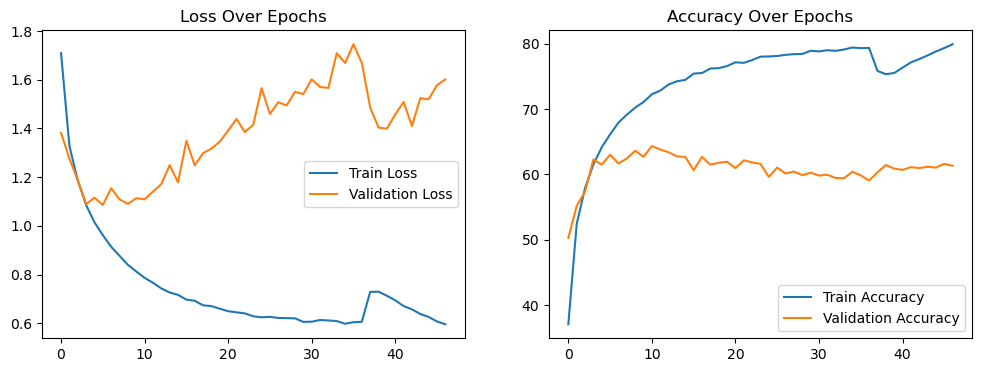

In [9]:
optimizer_adam = optim.Adam(net_simple.parameters(), lr=0.001)

# Increase the number of epochs
num_epochs = 10

for epoch in range(num_epochs):  # loop over the dataset multiple times
    train_loss, valid_loss = 0.0, 0.0
    correct, total = 0, 0
    
    # Training loop
    net_simple.train()
    for data in trainloader:
        inputs, labels = data
        optimizer_adam.zero_grad()
        outputs = net_simple(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adam.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation loop
    net_simple.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_simple(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)

    print(f'Epoch {epoch+1}, Train loss: {train_loss / len(trainloader):.2f}, Accuracy: {100 * correct / total:.2f}%, Validation loss: {valid_loss / len(testloader):.2f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')

plot_training(history)


In [ ]:
import torch.nn.functional as F

# CNN with an additional convolutional layer and dropout
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # New layer
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Adjust input features according to new conv layer
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  # New layer
        x = x.view(-1, 128 * 4 * 4)  # Adjust flattening
        x = self.dropout(x)  # Dropout layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the network
net = ModifiedCNN()

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_adam.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adam.step()
        running_loss += loss.item()

    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)
    
    print(f'Epoch {epoch + 1}, Train loss: {running_loss / len(trainloader):.2f}, '
          f'Accuracy: {100 * correct / total:.2f}%, '
          f'Validation loss: {val_loss / len(testloader):.2f}, '
          f'Validation Accuracy: {100 * correct / total:.2f}%')
    
plot_training(history)


In [ ]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
# Initialize the network
net = AdvancedCNN()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_adam.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adam.step()
        running_loss += loss.item()

    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # Saving history for plots
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100 * correct / total)
    history['val_loss'].append(valid_loss / len(testloader))
    history['val_acc'].append(100 * val_correct / val_total)
    
    print(f'Epoch {epoch + 1}, Train loss: {running_loss / len(trainloader):.2f}, '
          f'Accuracy: {100 * correct / total:.2f}%, '
          f'Validation loss: {val_loss / len(testloader):.2f}, '
          f'Validation Accuracy: {100 * correct / total:.2f}%')
    
plot_training(history)
